# Anomaly Detection with Autoencoder

### Running Code
Using course provided "experiments" environment is recommended.

### Model Loading
Model saving and loading functionality is implemented after training cell. Run all cells, interrupt training, continue with cell "Loading model".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Constants
DEBUG = True
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
BATCHSIZE = 256
WORKERS = 4
EPOCHS = 20
LEARNING_RATE = 0.1
TRAINING_SHOW_UPDATES = 1

NOISY_SIZE = 100
NOISE_VALUE = 0.2

MODEL_PATH = "Models/Autoencoder_CNN.pth"

n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


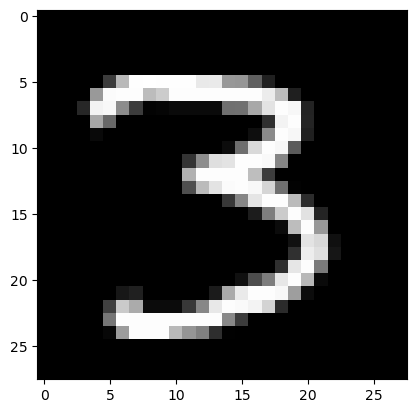

Label: 3


In [3]:
# Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split data into test, validation, and training sets
data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n].astype(np.float32) / 255.0  # Normalize pixel values

data_validation = data[TEST_SIZE:(TEST_SIZE+VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n].astype(np.float32) / 255.0  # Normalize pixel values

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n].astype(np.float32) / 255.0  # Normalize pixel values

values_subset = values_test[:, :NOISY_SIZE]
labels_subset = labels_test[:NOISY_SIZE]


def show_image(values, index):
    """
    Display image in np format.
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

if DEBUG:
    print("n =", n)
    print("m =", m)
    print("labels_train.shape =", labels_train.shape)
    print("values_train.shape =", values_train.shape)
    print("labels_test.shape =", labels_test.shape)
    print("values_test.shape =", values_test.shape)
    show_image(values_train, 0)
    print("Label:", labels_train[0])
    

In [4]:
# Add Gaussian noise to the subset
noise = np.random.normal(0, NOISE_VALUE, values_subset.shape)
values_subset_noisy = values_subset + noise

# Clip the noisy images to ensure they remain within the valid pixel range [0, 1]
values_subset_noisy = np.clip(values_subset_noisy, 0, 1)

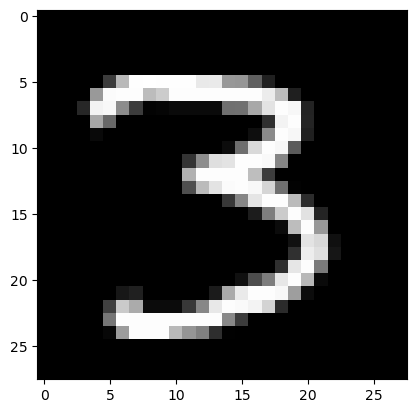

Label: 3


In [5]:
# Convert to PyTorch tensors
values_train = torch.tensor(values_train.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_train = torch.tensor(labels_train, dtype=torch.long)
dataset_train = TensorDataset(values_train, labels_train)
loader_train = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True, num_workers=WORKERS)

values_validation = torch.tensor(values_validation.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_validation = torch.tensor(labels_validation, dtype=torch.long)
dataset_validation = TensorDataset(values_validation, labels_validation)
loader_validation = DataLoader(dataset_validation, batch_size=BATCHSIZE, shuffle=False, num_workers=WORKERS)

values_test = torch.tensor(values_test.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_test = torch.tensor(labels_test, dtype=torch.long)
dataset_test = TensorDataset(values_test, labels_test)
loader_test = DataLoader(dataset_test, batch_size=BATCHSIZE, shuffle=False, num_workers=WORKERS)

values_subset_noisy_tensor = torch.tensor(values_subset_noisy.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_subset_tensor = torch.tensor(labels_subset, dtype=torch.long)
dataset_noisy = TensorDataset(values_subset_noisy_tensor, labels_subset_tensor)
loader_noisy = DataLoader(dataset_noisy, batch_size=256, shuffle=False)

if DEBUG:
    # show image after np -> tensor conversion
    sample_idx = 0
    plt.imshow(values_train[sample_idx].squeeze(), cmap="gray")
    plt.show()
    print("Label:", labels_train[sample_idx].item())


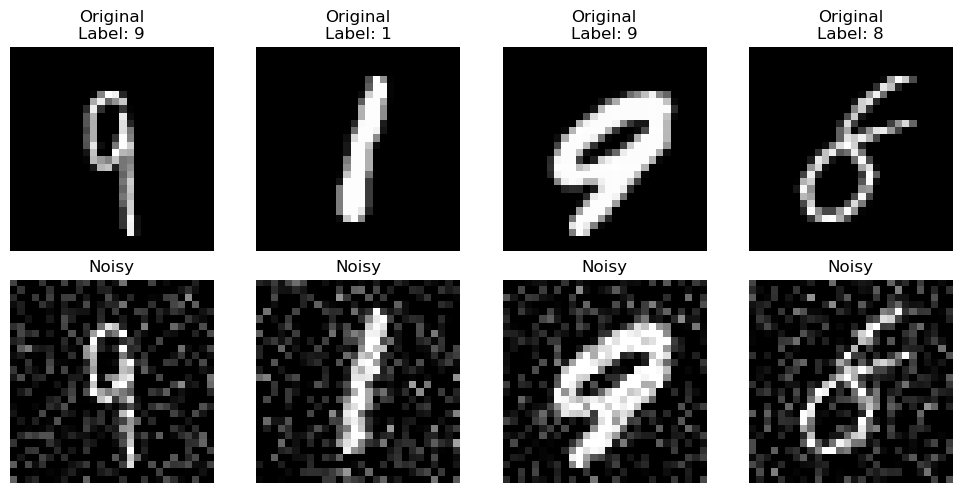

In [6]:
# Visualize four samples of original and corrupted images

num_samples = 4
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    # original image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(values_subset[:, i].reshape(28, 28), cmap="gray")
    plt.title(f"Original\nLabel: {labels_subset[i]}")
    plt.axis("off")

    # noisy image
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(values_subset_noisy[:, i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28x1 -> 14x14x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14x16 ->7x7x32
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7x32 -> 14x14x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14x16 ->28x28x1
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = Autoencoder_CNN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)  # SGD optimizer

loss_train_history = []
loss_validation_history = []

sample = torch.randn(1, 1, 28, 28).to(device)  # Sample input
output = model(sample)
print("Output shape:", output.shape)


Output shape: torch.Size([1, 1, 28, 28])


Epoch [0/20], Train Loss: 0.112, Validation Loss: 0.097


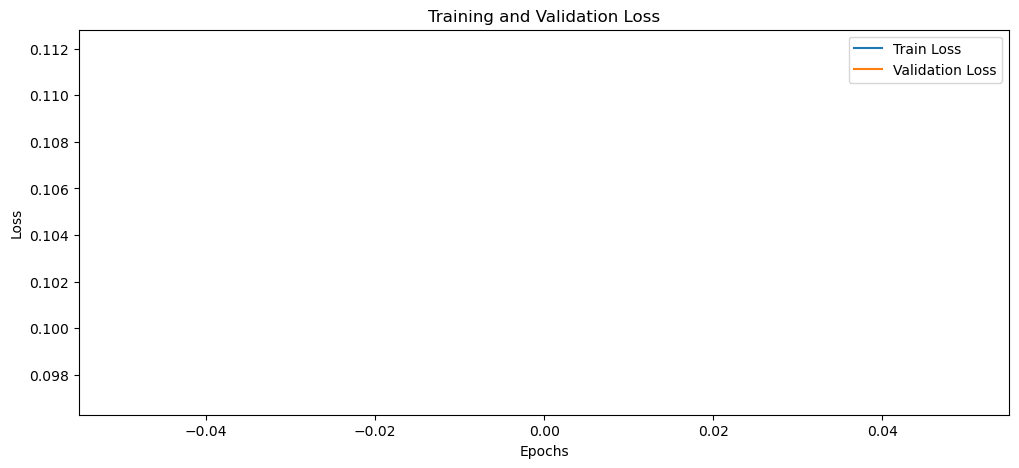

Epoch [1/20], Train Loss: 0.095, Validation Loss: 0.094


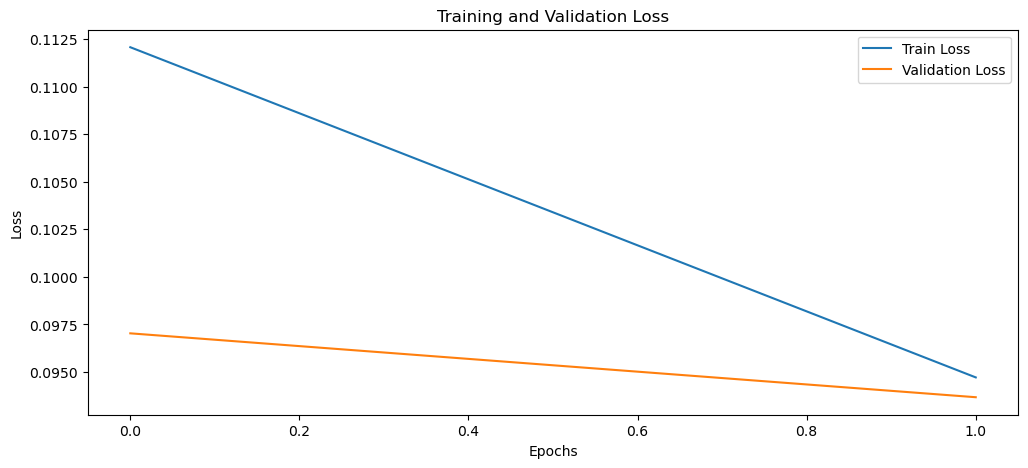

Epoch [2/20], Train Loss: 0.090, Validation Loss: 0.085


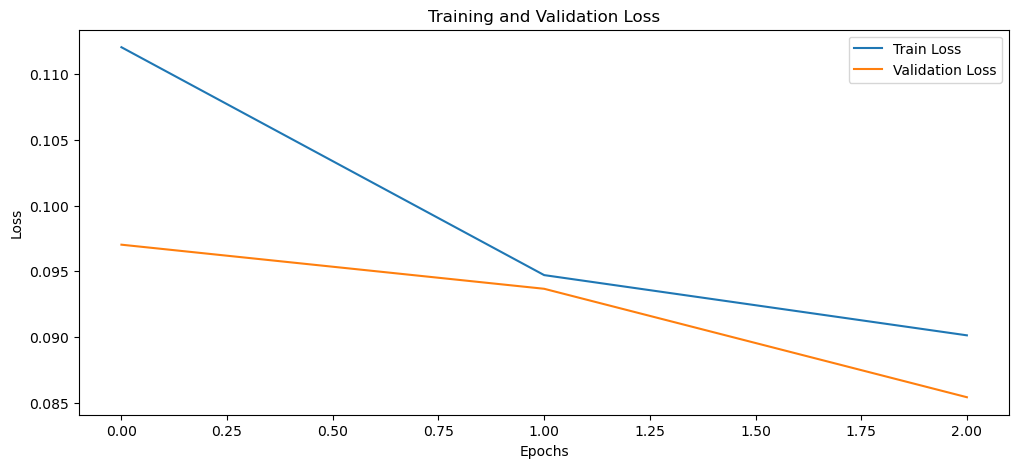

Epoch [3/20], Train Loss: 0.071, Validation Loss: 0.054


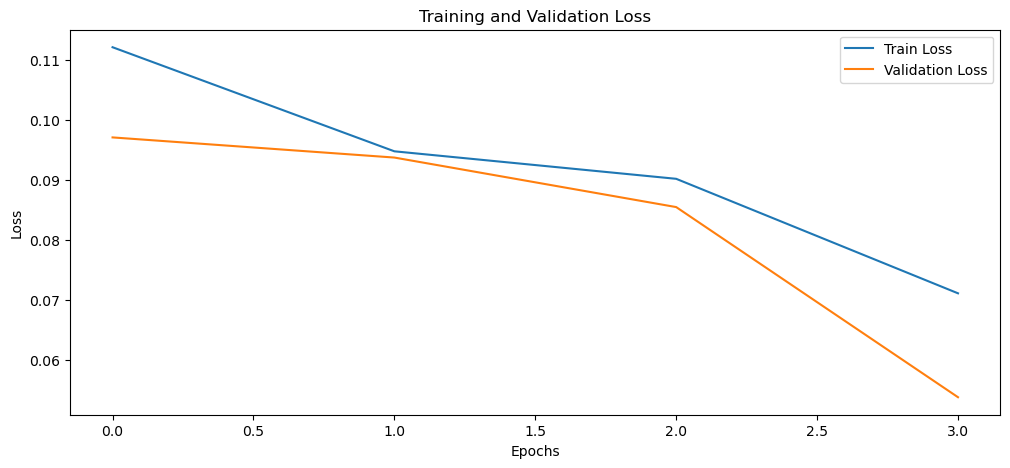

Epoch [4/20], Train Loss: 0.042, Validation Loss: 0.035


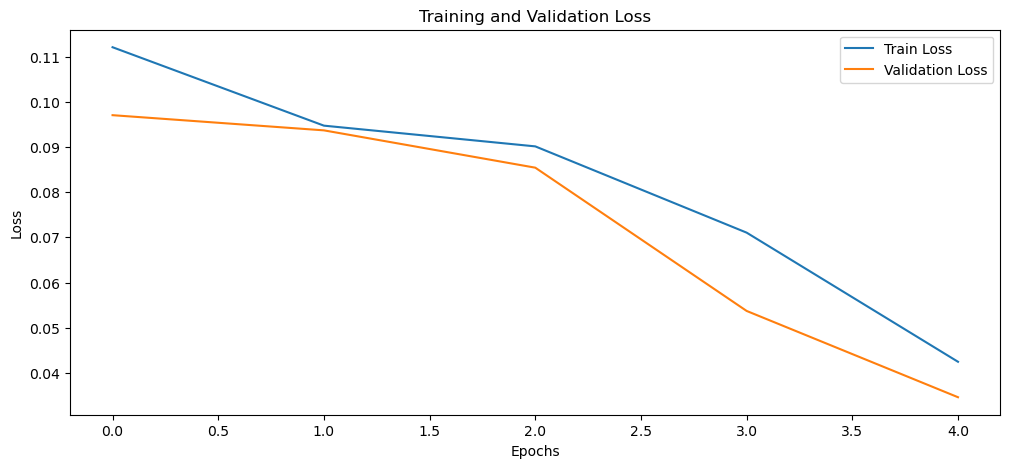

Epoch [5/20], Train Loss: 0.030, Validation Loss: 0.025


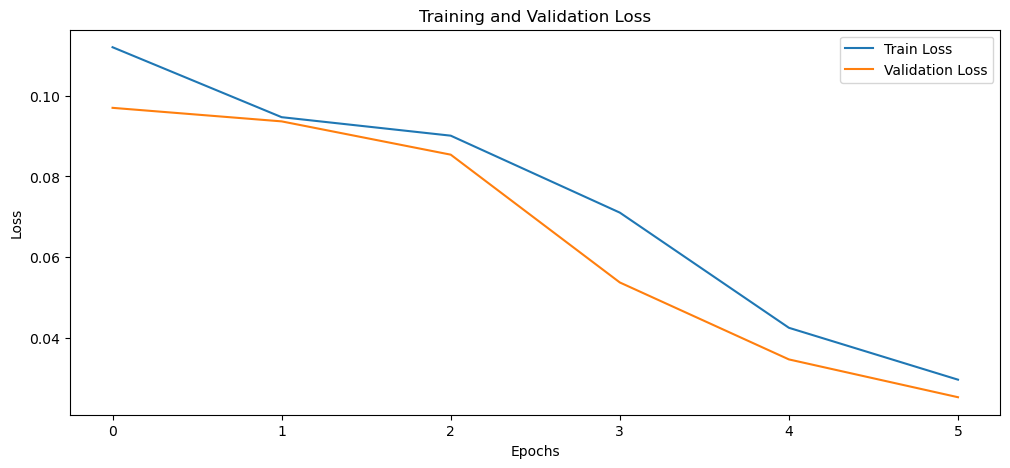

KeyboardInterrupt: 

In [9]:
# Training loop
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(loader_train):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(loader_train)
    loss_train_history.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in loader_validation:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    val_loss /= len(loader_validation)
    loss_validation_history.append(val_loss)

    # Print training progress
    if epoch % TRAINING_SHOW_UPDATES == 0:
        print(f"Epoch [{epoch}/{EPOCHS}], Train Loss: {epoch_loss:.3f}, Validation Loss: {val_loss:.3f}")
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))
        plt.plot(loss_train_history, label="Train Loss")
        plt.plot(loss_validation_history, label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

In [ ]:
# Saving and loading model

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# Save the trained model
save_model(model, MODEL_PATH)

Model saved to Models/Autoencoder_CNN.pth


In [ ]:
# Loading model

def load_model(model, filepath, device):
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    print(f"Model loaded from {filepath}")
    return model

model = Autoencoder_CNN().to(device)  # Reinitialize the model
model = load_model(model, MODEL_PATH, device)

Model loaded from Models/Autoencoder_CNN.pth


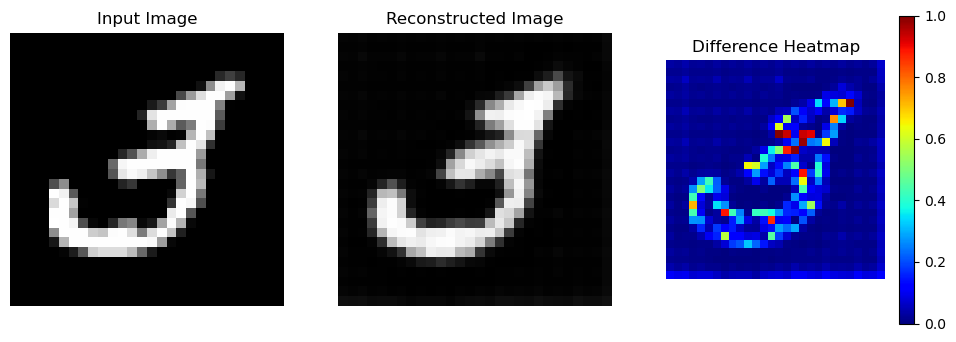

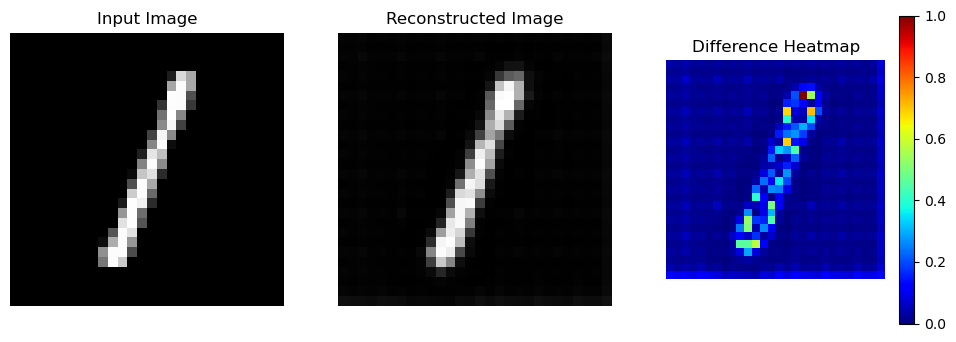

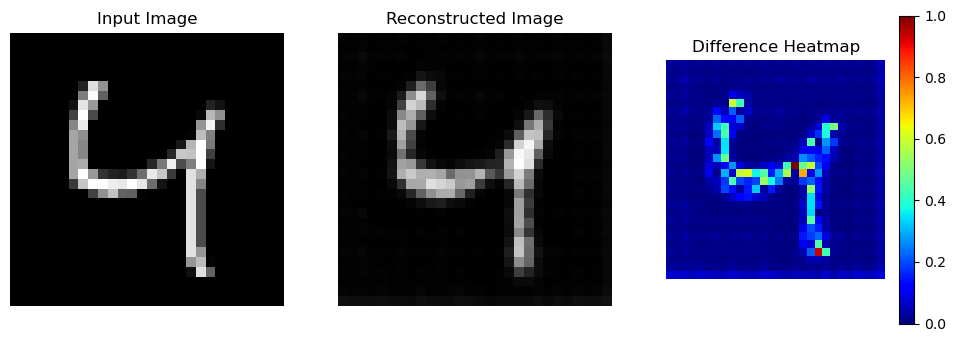

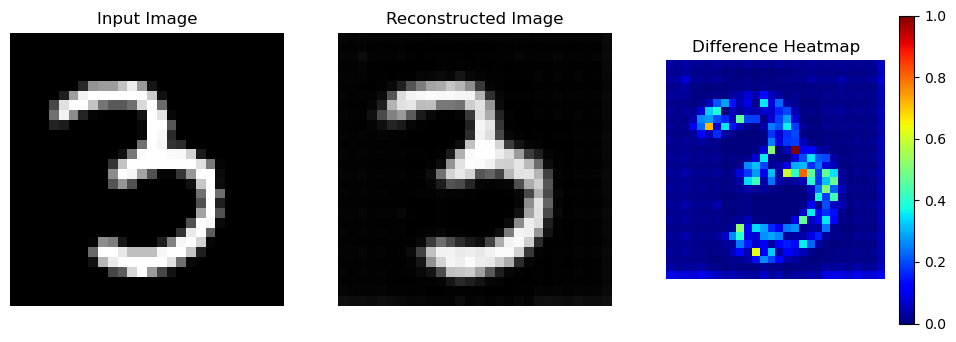

Test Loss: 0.006


In [ ]:
def evaluate(loader, num_images=4):
    """Evaluate the model's reconstruction performance and highlight input-output differences."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()

            if i == 0:  # Only visualize for the first batch
                for j in range(min(num_images, images.size(0))):
                    input_image = images[j].cpu().squeeze().numpy()
                    output_image = outputs[j].cpu().squeeze().numpy()
                    difference_image = np.abs(input_image - output_image)

                    # Normalize difference for better visualization
                    diff_normalized = (difference_image - difference_image.min()) / (difference_image.max() - difference_image.min() + 1e-8)

                   
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(input_image, cmap="gray")
                    plt.title("Input Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.imshow(output_image, cmap="gray")
                    plt.title("Reconstructed Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.imshow(diff_normalized, cmap="jet")  # using a heatmap
                    plt.colorbar()  # show intensity scale
                    plt.title("Difference Heatmap")
                    plt.axis("off")

                    plt.show()

    return total_loss / len(loader)


test_loss = evaluate(loader_test)
print(f"Test Loss: {test_loss:.3f}")



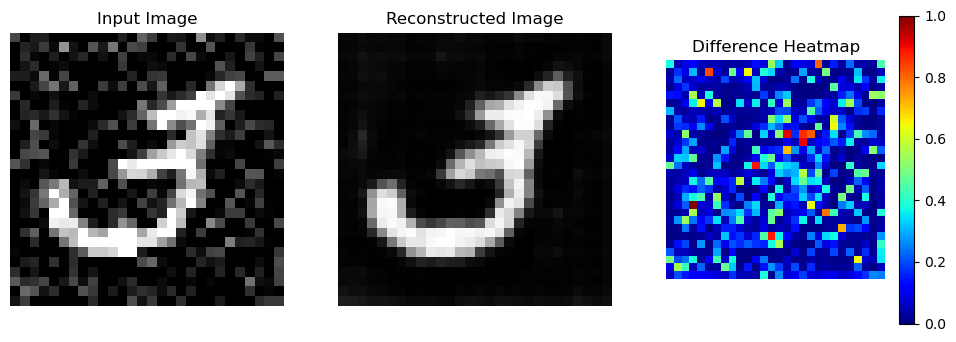

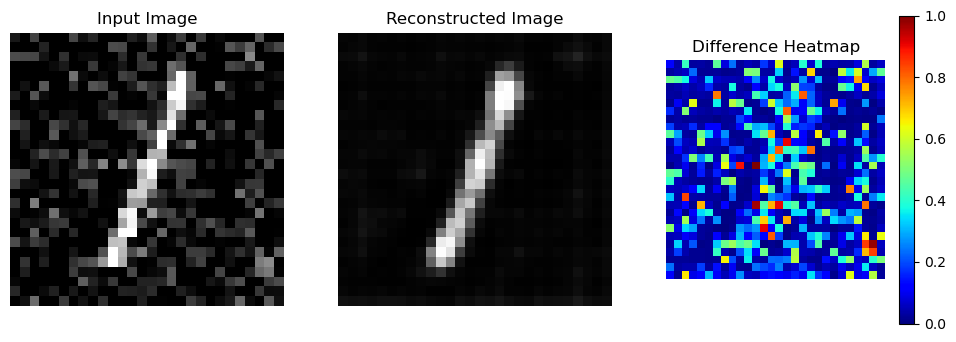

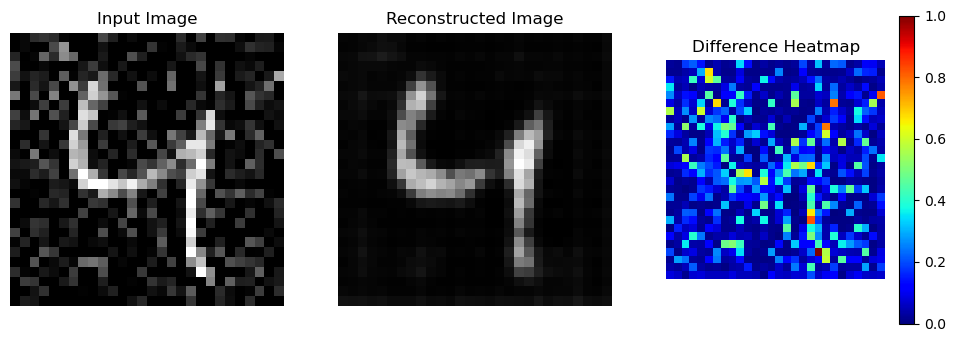

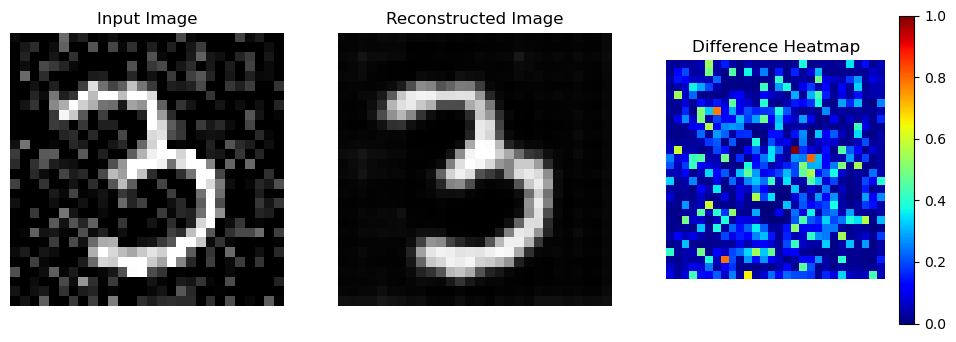

Test Loss: 0.021


In [ ]:
test_loss = evaluate(loader_noisy)
print(f"Test Loss: {test_loss:.3f}")

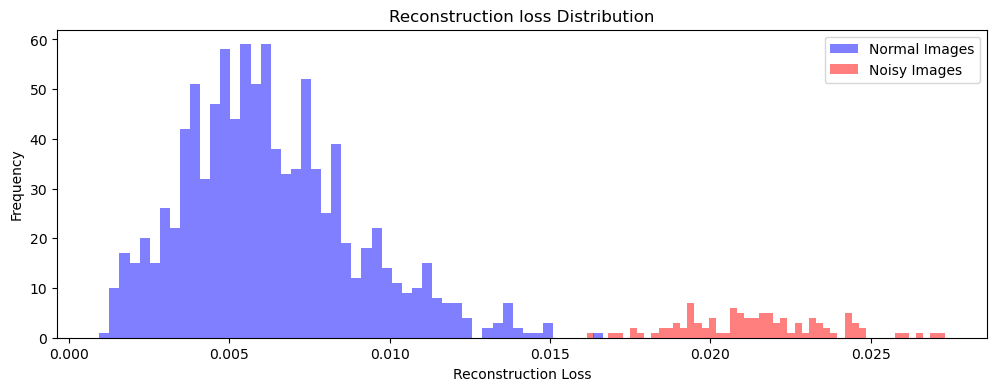

In [ ]:

def compute_losses(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            # Compute loss for each image in the batch
            loss = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # MSE loss per image
            losses.extend(loss.cpu().numpy())  # convert to numpy and store
    return losses


def plot_loss_distribution(normal_losses, noisy_losses):
    plt.figure(figsize=(12, 4))
    plt.hist(normal_losses, bins=50, alpha=0.5, label='Normal Images', color='blue')
    plt.hist(noisy_losses, bins=50, alpha=0.5, label='Noisy Images', color='red')
    plt.title('Reconstruction loss Distribution')
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Compute losses for normal and noisy images
normal_losses = compute_losses(loader_test)
noisy_losses = compute_losses(loader_noisy)

plot_loss_distribution(normal_losses, noisy_losses)

In [ ]:
def classify_images(loader, threshold, is_anomaly=False):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            # Compute loss for each image in the batch
            loss = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # MSE loss per image
            y_true.extend([1 if is_anomaly else 0] * images.size(0))  # 1 for anomalies, 0 for normal
            y_pred.extend([1 if l.item() > threshold else 0 for l in loss])
    return y_true, y_pred

def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_true == 1) & (y_pred == 1))  
    FP = np.sum((y_true == 0) & (y_pred == 1))  
    TN = np.sum((y_true == 0) & (y_pred == 0))  
    FN = np.sum((y_true == 1) & (y_pred == 0))  
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1, TP, FP, TN, FN


def plot_confusion_matrix(TP, FP, TN, FN):
    cm = np.array([[TP, FN], [FP, TN]])
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='viridis', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    labels = ['Anomaly (Positive)', 'Normal (Negative)']
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', 
                     color='Grey')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

TP = 100
FP = 1
TN = 999
FN = 0
Precision = 0.990
Recall = 1.000
F1 Score = 0.995


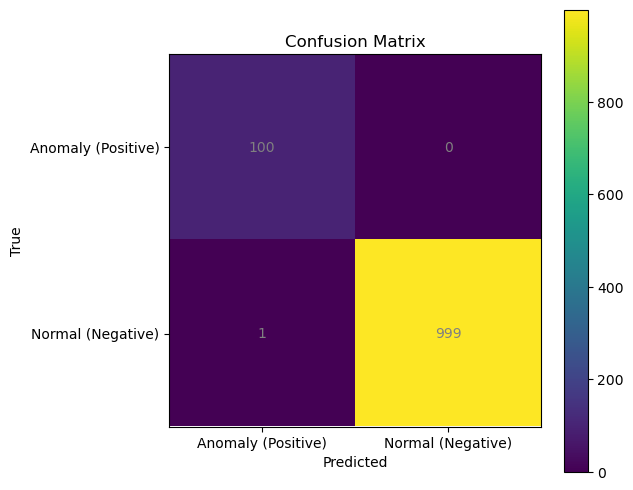

In [ ]:
ANOMALY_LOSS_THRESHOLD = 0.016

# Classify normal and noisy images using the threshold
y_true_normal, y_pred_normal = classify_images(loader_test, ANOMALY_LOSS_THRESHOLD, is_anomaly=False)
y_true_noisy, y_pred_noisy = classify_images(loader_noisy, ANOMALY_LOSS_THRESHOLD, is_anomaly=True)

y_true = y_true_normal + y_true_noisy
y_pred = y_pred_normal + y_pred_noisy

precision, recall, f1, TP, FP, TN, FN = calculate_metrics(y_true, y_pred)


print(f"TP = {TP}")
print(f"FP = {FP}")
print(f"TN = {TN}")
print(f"FN = {FN}")

print(f"Precision = {precision:.3f}")
print(f"Recall = {recall:.3f}")
print(f"F1 Score = {f1:.3f}")


plot_confusion_matrix(TP, FP, TN, FN)